In [2]:
from tqdm import tqdm
import numpy as np
from scipy import sparse
from embedding_functions import *
from experiment_setup import *
import torch_geometric
from sklearn.decomposition import PCA
from torch_geometric.nn import GCNConv
from torch.functional import F
import torch
from gnn_embedding_functions import UGCN, block_GCN



In [3]:

def mask_split(mask, split_props, seed=0, mode='transductive'):
    np.random.seed(seed)
    
    n, T = mask.shape
    
    if mode == 'transductive':
        # Flatten mask array into one dimension in blocks of nodes per time
        flat_mask = mask.T.reshape(-1)
        n_masks = np.sum(flat_mask)
        
        # Split shuffled flatten mask array indices into correct proportions
        flat_mask_idx = np.where(flat_mask)[0]
        np.random.shuffle(flat_mask_idx)
        split_ns = np.cumsum([round(n_masks * prop) for prop in split_props[:-1]])
        split_idx = np.split(flat_mask_idx, split_ns)
        
    if mode == 'semi-inductive':
        # Find time such that final proportion of masks happen after that time
        T_trunc = np.where(np.cumsum(np.sum(mask, axis=0) / np.sum(mask)) >= 1 - split_props[-1])[0][0]
        
        # Flatten mask arrays into one dimension in blocks of nodes per time
        flat_mask_start = mask[:, :T_trunc].T.reshape(-1)
        flat_mask_end = mask[:, T_trunc:].T.reshape(-1)
        n_masks_start = np.sum(flat_mask_start)
        
        # Split starting shuffled flatten mask array into correct proportions
        flat_mask_start_idx = np.where(flat_mask_start)[0]
        np.random.shuffle(flat_mask_start_idx)
        split_props_start = split_props[:-1] / np.sum(split_props[:-1])
        split_ns = np.cumsum([round(n_masks_start * prop) for prop in split_props_start[:-1]])
        split_idx = np.split(flat_mask_start_idx, split_ns)
    
        # Place finishing flatten mask array at the end
        split_idx.append(n * T_trunc + np.where(flat_mask_end)[0])
    
    split_masks = np.array([[False] * n * T for _ in range(len(split_props))])
    for i in range(len(split_props)):
        split_masks[i, split_idx[i]] = True
        
    return split_masks

In [4]:
def GCN_val(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_weight)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
    acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.

    return acc


class GCN_UA(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset_UA.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset_UA.num_classes)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x


class GCN_BD(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset_BD.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset_BD.num_classes)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x


from gnn_embedding_functions import (
    Dynamic_Network,
    Unfolded_Network,
    Block_Diagonal_Network,
)

In [5]:
# Make the SBM data
n = 300
As, tau, _ = make_iid(n=n, T=2, iid_prob=0.9)
As = [sparse.csr_matrix(A) for A in As]
T = len(As)
node_labels = np.tile(tau, T)


In [6]:
data_mask = np.array([[True] * T for _ in range(n)])

for t in range(T):
    data_mask[np.where(np.sum(As[t], axis=0) == 0)[0], t] = False
    # data_mask[np.where(node_labels == label_dict['Teachers'])[0], t] = False
    
num_classes = np.unique(node_labels).shape[0]
print(f'Percentage of usable node/time pairs: {100 * np.sum(data_mask) / (n * T) :02.1f}%')

Percentage of usable node/time pairs: 100.0%


In [7]:
props = np.array([0.2, 0.1, 0.35, 0.35])
train_mask, valid_mask, calib_mask, test_mask = mask_split(data_mask, props, mode='transductive')

print(f'Percentage train: {100 * np.sum(train_mask) / np.sum(data_mask) :02.1f}%')
print(f'Percentage valid: {100 * np.sum(valid_mask) / np.sum(data_mask) :02.1f}%')
print(f'Percentage calib: {100 * np.sum(calib_mask) / np.sum(data_mask) :02.1f}%')
print(f'Percentage test:  {100 * np.sum(test_mask)  / np.sum(data_mask) :02.1f}%')

Percentage train: 20.0%
Percentage valid: 10.0%
Percentage calib: 35.0%
Percentage test:  35.0%


In [9]:

# conformal parameters
alpha = 0.1

# methods = ["Block GCN"]
methods = ["UGCN", "Block GCN"]

# We want
# Accuracy+error, marginal cov+error, setsize+error, TSC+error
results_for_each_method = []

summaries = []


print("Running at reduced parameters")
num_epochs = 1000


ya_ugcn, model, best_model_acc = UGCN(
    As,
    node_labels,
    model_save_dir="saved_models/sbm_UGCN.pt",
    train_mask=train_mask,
    val_mask=valid_mask,
    test_mask=test_mask,  # Model doesn't train on test, it just prints the accuracy
    num_epochs=num_epochs,
    # epoch_save_dir="saved_epochs/sbm_UGCN",
    return_model=True,
    hidden_channels=32,
)


ya_block, model, best_model_acc = block_GCN(
    As,
    node_labels,
    model_save_dir="saved_models/sbm_block_GCN.pt",
    train_mask=train_mask,
    val_mask=valid_mask,
    test_mask=test_mask,  # Model doesn't train on test, it just prints the accuracy
    num_epochs=num_epochs,
    # epoch_save_dir="saved_epochs/sbm_block_GCN",
    return_model=True,
    hidden_channels=32,
)



Running at reduced parameters
Using a single identity for unfolded attributes
Training Unfolded GCN...


  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 38/1000 [00:08<03:38,  4.40it/s]


KeyboardInterrupt: 

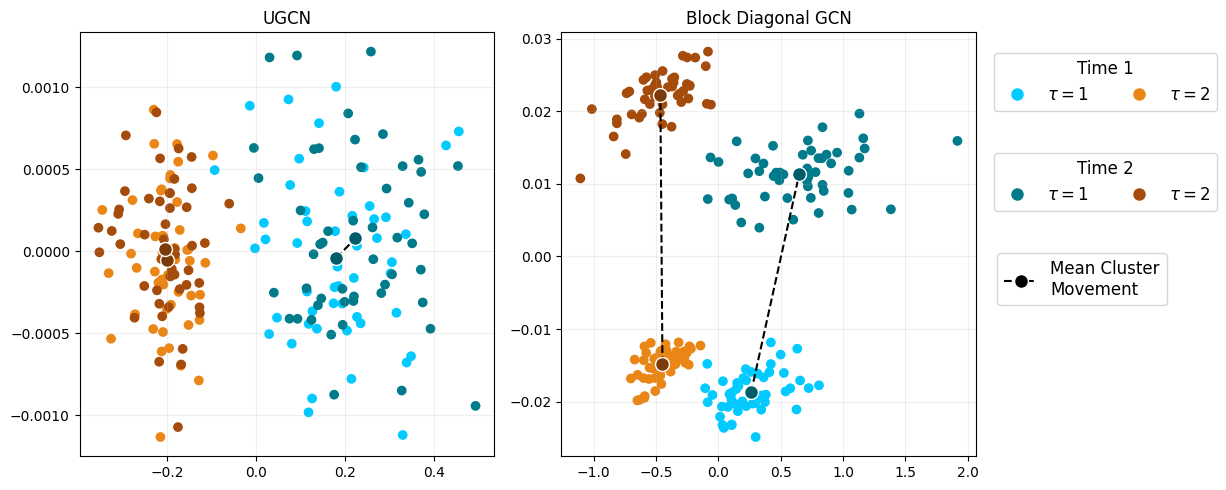

In [ ]:
from matplotlib.lines import Line2D


# Visualise the drift in the naive GNN embedding

light_tau_colours = {0: "#00CAFF", 1: "#EA8615"}
dark_tau_colours = {0: "#007B8B", 1: "#A54B0B"}
darker_tau_colours = {0: "#005B6B", 1: "#7A3B0B"}

from sklearn.decomposition import PCA

ya_ugcn_pca = PCA(n_components=2).fit_transform(ya_ugcn)
ya_block_pca = PCA(n_components=2).fit_transform(ya_block)

embeddings_by_method = [ya_ugcn_pca, ya_block_pca]
methods = ["UGCN", "Block Diagonal GCN"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, embeddings in enumerate(embeddings_by_method):
    axs[i].grid(alpha=0.2)
    axs[i].scatter(
        embeddings[0:n, 0], embeddings[0:n, 1], c=[light_tau_colours[t] for t in tau]
    )
    axs[i].scatter(
        embeddings[n : 2 * n, 0],
        embeddings[n : 2 * n, 1],
        c=[dark_tau_colours[t] for t in tau],
    )

    axs[i].set_title(f"{methods[i]}")

    # Get observed value of the test
    for j in range(2):
        mean_x_1 = np.mean(embeddings[0:n, 0][tau == j])
        mean_y_1 = np.mean(embeddings[0:n, 1][tau == j])
        mean_x_2 = np.mean(embeddings[n : 2 * n, 0][tau == j])
        mean_y_2 = np.mean(embeddings[n : 2 * n, 1][tau == j])

        axs[i].plot(
            [mean_x_1, mean_x_2],
            [mean_y_1, mean_y_2],
            # c="black",
            marker="o",
            # set line colour to black
            c="black",
            mfc=darker_tau_colours[j],
            linestyle="--",
            markersize=10,
            mec="white",
        )


node_elements_1 = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=1$",
        markerfacecolor=light_tau_colours[0],
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=2$",
        markerfacecolor=light_tau_colours[1],
        markersize=10,
    ),
]
node_elements_2 = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=1$",
        markerfacecolor=dark_tau_colours[0],
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=2$",
        markerfacecolor=dark_tau_colours[1],
        markersize=10,
    ),
]

fig.legend(
    handles=node_elements_1,
    loc="upper right",
    bbox_to_anchor=(1.23, 0.9),  # Adjust these values to move the legend
    title="Time 1",
    ncol=2,
    title_fontsize="large",
    fontsize="large",
)
fig.legend(
    handles=node_elements_2,
    loc="upper right",
    bbox_to_anchor=(1.23, 0.7),  # Adjust these values to move the legend
    title="Time 2",
    ncol=2,
    title_fontsize="large",
    fontsize="large",
)

line_elements = [
    Line2D(
        [0, 1],
        [0, 1],
        c="black",
        marker="o",
        linestyle="--",
        label="Mean Cluster\nMovement",
        mec="white",
        markersize=10,
    ),
]
fig.legend(
    handles=line_elements,
    loc="upper right",
    bbox_to_anchor=(1.18, 0.5),  # Adjust these values to move the legend
    # title="Mean node embedding",
    title_fontsize="large",
    fontsize="large",
)

plt.tight_layout()




In [ ]:


# conformal parameters
alpha = 0.1

# methods = ["Block GCN"]
methods = ["UGCN", "Block GCN"]

# We want
# Accuracy+error, marginal cov+error, setsize+error, TSC+error
results_for_each_method = []

summaries = []


num_epochs = 80

train_mask, val_mask, calib_mask, test_mask = transductive_masks(n, T, splits=[0.2, 0.1, 0.2, 0.5])
print("warning: training on all of the data!! \n\n\n")
train_mask = train_mask | val_mask | calib_mask | test_mask

ya_ugcn, model, best_model_acc = UGCN(
    As,
    node_labels,
    model_save_dir="saved_models/sbm_UGCN.pt",
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,  # Model doesn't train on test, it just prints the accuracy
    num_epochs=num_epochs,
    # epoch_save_dir="saved_epochs/sbm_UGCN",
    return_model=True,
    hidden_channels=32,
)


ya_block, model, best_model_acc = block_GCN(
    As,
    node_labels,
    model_save_dir="saved_models/sbm_block_GCN.pt",
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,  # Model doesn't train on test, it just prints the accuracy
    num_epochs=num_epochs,
    # epoch_save_dir="saved_epochs/sbm_block_GCN",
    return_model=True,
    hidden_channels=32,
)






Using a single identity for unfolded attributes
Training Unfolded GCN...


  6%|▋         | 5/80 [00:10<02:32,  2.03s/it]

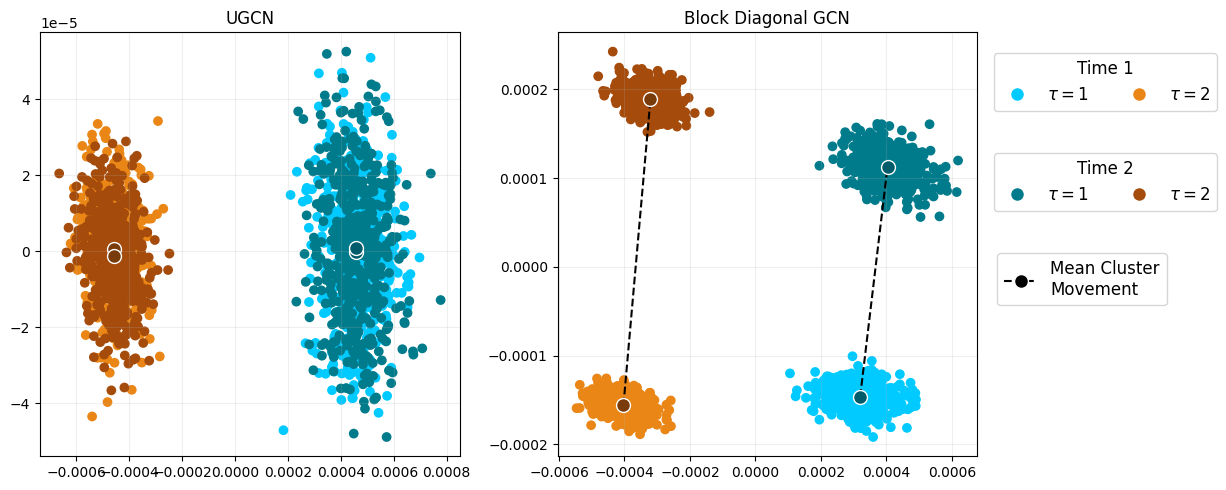

In [ ]:
from matplotlib.lines import Line2D


# Visualise the drift in the naive GNN embedding

light_tau_colours = {0: "#00CAFF", 1: "#EA8615"}
dark_tau_colours = {0: "#007B8B", 1: "#A54B0B"}
darker_tau_colours = {0: "#005B6B", 1: "#7A3B0B"}

from sklearn.decomposition import PCA

ya_ugcn_pca = PCA(n_components=2).fit_transform(ya_ugcn)
ya_block_pca = PCA(n_components=2).fit_transform(ya_block)

embeddings_by_method = [ya_ugcn_pca, ya_block_pca]

methods = ["UGCN", "Block Diagonal GCN"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, embeddings in enumerate(embeddings_by_method):
    axs[i].grid(alpha=0.2)
    axs[i].scatter(
        embeddings[0:n, 0], embeddings[0:n, 1], c=[light_tau_colours[t] for t in tau]
    )
    axs[i].scatter(
        embeddings[n : 2 * n, 0],
        embeddings[n : 2 * n, 1],
        c=[dark_tau_colours[t] for t in tau],
    )

    axs[i].set_title(f"{methods[i]}")

    # Get observed value of the test
    for j in range(2):
        mean_x_1 = np.mean(embeddings[0:n, 0][tau == j])
        mean_y_1 = np.mean(embeddings[0:n, 1][tau == j])
        mean_x_2 = np.mean(embeddings[n : 2 * n, 0][tau == j])
        mean_y_2 = np.mean(embeddings[n : 2 * n, 1][tau == j])

        axs[i].plot(
            [mean_x_1, mean_x_2],
            [mean_y_1, mean_y_2],
            # c="black",
            marker="o",
            # set line colour to black
            c="black",
            mfc=darker_tau_colours[j],
            linestyle="--",
            markersize=10,
            mec="white",
        )


node_elements_1 = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=1$",
        markerfacecolor=light_tau_colours[0],
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=2$",
        markerfacecolor=light_tau_colours[1],
        markersize=10,
    ),
]
node_elements_2 = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=1$",
        markerfacecolor=dark_tau_colours[0],
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=r"$\tau=2$",
        markerfacecolor=dark_tau_colours[1],
        markersize=10,
    ),
]

fig.legend(
    handles=node_elements_1,
    loc="upper right",
    bbox_to_anchor=(1.23, 0.9),  # Adjust these values to move the legend
    title="Time 1",
    ncol=2,
    title_fontsize="large",
    fontsize="large",
)
fig.legend(
    handles=node_elements_2,
    loc="upper right",
    bbox_to_anchor=(1.23, 0.7),  # Adjust these values to move the legend
    title="Time 2",
    ncol=2,
    title_fontsize="large",
    fontsize="large",
)

line_elements = [
    Line2D(
        [0, 1],
        [0, 1],
        c="black",
        marker="o",
        linestyle="--",
        label="Mean Cluster\nMovement",
        mec="white",
        markersize=10,
    ),
]
fig.legend(
    handles=line_elements,
    loc="upper right",
    bbox_to_anchor=(1.18, 0.5),  # Adjust these values to move the legend
    # title="Mean node embedding",
    title_fontsize="large",
    fontsize="large",
)

plt.tight_layout()


